### Import all the dependencies

In [35]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

### Load the dataset

In [36]:
data = pd.read_csv('himangini_train.tsv', sep='\t')

#### Take a peek at the dataset

In [37]:
data.head()

,file,value,statement,topic,name,occupation,state,party,barely true counts,false counts,half true counts,mostly true counts,pants on fire counts,context,date,edited by,researchedby,source
0,2635.json,FALSE,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,10/20/10,"Brenda Bell, W. Gardner Selby",Meghan Ashford_Grooms,NaN
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,NaN,NaN,NaN,NaN
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,NaN,NaN,NaN,NaN
3,1123.json,FALSE,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,NaN,NaN,NaN,NaN
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,NaN,NaN,NaN,NaN


### Data Cleaning and Preprocessing:
1. **Tokenization**: Split the text into sentences and the sentences into words. 
2. **Lowercase** the words and **remove punctuation**.
3. Words that have fewer than 3 characters are removed.
4. All **stopwords** are removed.
5. Words are **lemmatized** — words in third person are changed to first person and verbs in past and future tenses are changed into present.
6. Words are **stemmed** — words are reduced to their root form.


In [38]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

data_text=data[['statement']]
data_text['index'] = data_text.index
documents = data_text
print(len(documents))
print(documents[:5])

10240
                                           statement  index
0  Says the Annies List political group supports ...      0
1  When did the decline of coal start? It started...      1
2  Hillary Clinton agrees with John McCain "by vo...      2
3  Health care reform legislation is likely to ma...      3
4  The economic turnaround started at the end of ...      4


#### Loading gensim and nltk libraries

In [39]:
import gensim
import nltk
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
np.random.seed(2018)
nltk.download('wordnet')
stemmer = SnowballStemmer('english')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/himangini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Write a function to perform lemmatize and stem preprocessing steps on the data set

In [40]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text,pos='v'))
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) >3:
            result.append(lemmatize_stemming(token))
    return result

#### Select a document to preview after preprocessing

In [41]:
doc_sample = documents[documents['index'] == 0].values[0][0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['Says', 'the', 'Annies', 'List', 'political', 'group', 'supports', 'third-trimester', 'abortions', 'on', 'demand.']


 tokenized and lemmatized document: 
['say', 'anni', 'list', 'polit', 'group', 'support', 'trimest', 'abort', 'demand']


#### Preprocess the headline text, saving the results as ‘processed_docs’

In [42]:
processed_docs = documents['statement'].map(preprocess)
processed_docs[:10]

0    [say, anni, list, polit, group, support, trime...
1    [declin, coal, start, start, natur, take, star...
2    [hillari, clinton, agre, john, mccain, vote, g...
3    [health, care, reform, legisl, like, mandat, f...
4                    [econom, turnaround, start, term]
5    [chicago, bear, start, quarterback, year, tota...
6               [dunnam, live, district, repres, year]
7    [person, stage, work, activ, year, pass, russ,...
8    [take, million, oregon, lotteri, fund, port, n...
9    [say, primari, oppon, glenn, grothman, leibham...
Name: statement, dtype: object

## Bag of Words on the Data set
#### Create a dictionary from ‘processed_docs’ containing the number of times a word appears in the training set

In [43]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k,v in dictionary.iteritems():
    print(k,v)
    count+=1
    if count > 10:
        break

0 abort
1 anni
2 demand
3 group
4 list
5 polit
6 say
7 support
8 trimest
9 administr
10 begin


### Gensim filter_extremes
#### Filter out tokens that appear in 
1. less than 15 documents (absolute number)
2. more than 0.5 documents (fraction of total corpus size, not absolute number). 
3. After the above two steps, keep only the first 100k most frequent tokens. 

#### Visuale the shape of the corpus

In [44]:
processed_docs.shape

(10240,)

In [45]:
dictionary.filter_extremes(no_below=15,no_above=0.5,keep_n=100000)

### Gensim doc2bow
For each document I have created a dictionary reporting how many words and how many times those words appear. 
Save this to ‘bow_corpus’, then check our selected document earlier.

In [72]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[:10]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)],
 [(7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 3),
  (16, 1)],
 [(9, 1),
  (12, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1)],
 [(25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1)],
 [(15, 1), (33, 1), (34, 1)],
 [(15, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1)],
 [(40, 1), (41, 1), (42, 1), (43, 1)],
 [(32, 1),
  (40, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1)],
 [(16, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1)],
 [(5, 1),
  (24, 1),
  (54, 1),
  (58, 1),
  (59, 2),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1)]]

#### Preview Bag Of Words for our sample preprocessed document

In [47]:
bow_doc_0 = bow_corpus[0]
for i in range(len(bow_doc_0)):
    print("{} - {}".format(dictionary[bow_doc_0[i][0]],bow_doc_0[i][1]))

abort - 1
demand - 1
group - 1
list - 1
polit - 1
say - 1
support - 1


## TF-IDF
Create tf-idf model object using models.TfidfModel on ‘bow_corpus’ and save it to ‘tfidf’, 
then apply transformation to the entire corpus and call it ‘corpus_tfidf’. 
Finally we preview TF-IDF scores for our first document.

In [48]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint (doc)
    break

[(0, 0.3397402827336795),
 (1, 0.5002880765433487),
 (2, 0.4088224168287155),
 (3, 0.4639566513984633),
 (4, 0.40750764496407926),
 (5, 0.10879086838115597),
 (6, 0.27202739591951525)]


### Running LDA using Bag of Words
Train our lda model using gensim.models.LdaMulticore and save it to ‘lda_model’

In [49]:
lda_model = gensim.models.LdaMulticore(bow_corpus,num_topics=10,id2word=dictionary,passes=2)
lda_model.print_topics(-1)

[(0,
  '0.058*"say" + 0.025*"state" + 0.017*"vote" + 0.015*"american" + 0.014*"texa" + 0.012*"year" + 0.012*"million" + 0.011*"percent" + 0.010*"billion" + 0.008*"america"'),
 (1,
  '0.040*"say" + 0.015*"vote" + 0.015*"care" + 0.014*"american" + 0.013*"state" + 0.010*"obamacar" + 0.010*"health" + 0.010*"year" + 0.009*"obama" + 0.009*"trump"'),
 (2,
  '0.045*"obama" + 0.040*"say" + 0.034*"presid" + 0.027*"barack" + 0.022*"year" + 0.014*"time" + 0.011*"rate" + 0.011*"illeg" + 0.010*"support" + 0.010*"immigr"'),
 (3,
  '0.043*"say" + 0.033*"state" + 0.028*"health" + 0.022*"care" + 0.011*"job" + 0.011*"plan" + 0.010*"year" + 0.010*"want" + 0.009*"obama" + 0.009*"budget"'),
 (4,
  '0.049*"percent" + 0.032*"say" + 0.025*"year" + 0.017*"state" + 0.011*"plan" + 0.008*"public" + 0.008*"employe" + 0.008*"peopl" + 0.008*"countri" + 0.007*"secur"'),
 (5,
  '0.042*"say" + 0.021*"vote" + 0.018*"school" + 0.017*"year" + 0.014*"obama" + 0.012*"spend" + 0.012*"democrat" + 0.011*"peopl" + 0.010*"presid"

#### For each topic, we will explore the words occuring in that topic and its relative weight.

In [50]:
for idx, topic in lda_model.print_topics(-1):
    print ("Topic: {} \n Words: {}".format(idx,topic))

Topic: 0 
 Words: 0.058*"say" + 0.025*"state" + 0.017*"vote" + 0.015*"american" + 0.014*"texa" + 0.012*"year" + 0.012*"million" + 0.011*"percent" + 0.010*"billion" + 0.008*"america"
Topic: 1 
 Words: 0.040*"say" + 0.015*"vote" + 0.015*"care" + 0.014*"american" + 0.013*"state" + 0.010*"obamacar" + 0.010*"health" + 0.010*"year" + 0.009*"obama" + 0.009*"trump"
Topic: 2 
 Words: 0.045*"obama" + 0.040*"say" + 0.034*"presid" + 0.027*"barack" + 0.022*"year" + 0.014*"time" + 0.011*"rate" + 0.011*"illeg" + 0.010*"support" + 0.010*"immigr"
Topic: 3 
 Words: 0.043*"say" + 0.033*"state" + 0.028*"health" + 0.022*"care" + 0.011*"job" + 0.011*"plan" + 0.010*"year" + 0.010*"want" + 0.009*"obama" + 0.009*"budget"
Topic: 4 
 Words: 0.049*"percent" + 0.032*"say" + 0.025*"year" + 0.017*"state" + 0.011*"plan" + 0.008*"public" + 0.008*"employe" + 0.008*"peopl" + 0.008*"countri" + 0.007*"secur"
Topic: 5 
 Words: 0.042*"say" + 0.021*"vote" + 0.018*"school" + 0.017*"year" + 0.014*"obama" + 0.012*"spend" + 0.01

### Running LDA using TF-IDF

In [51]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} \n Word: {}'.format(idx, topic))

Topic: 0 
 Word: 0.015*"say" + 0.012*"state" + 0.011*"year" + 0.009*"immigr" + 0.008*"illeg" + 0.008*"presid" + 0.008*"senat" + 0.007*"oppos" + 0.007*"obama" + 0.007*"hous"
Topic: 1 
 Word: 0.013*"percent" + 0.013*"state" + 0.012*"say" + 0.010*"million" + 0.009*"year" + 0.008*"obama" + 0.008*"presid" + 0.008*"spend" + 0.008*"feder" + 0.007*"governor"
Topic: 2 
 Word: 0.015*"year" + 0.010*"percent" + 0.010*"say" + 0.009*"school" + 0.009*"averag" + 0.008*"spend" + 0.008*"american" + 0.008*"student" + 0.008*"state" + 0.008*"unemploy"
Topic: 3 
 Word: 0.015*"state" + 0.012*"say" + 0.012*"year" + 0.011*"health" + 0.010*"percent" + 0.010*"billion" + 0.009*"nation" + 0.009*"obamacar" + 0.009*"insur" + 0.008*"job"
Topic: 4 
 Word: 0.014*"job" + 0.012*"say" + 0.012*"obama" + 0.012*"presid" + 0.010*"month" + 0.010*"state" + 0.009*"creat" + 0.009*"year" + 0.008*"rate" + 0.008*"percent"
Topic: 5 
 Word: 0.017*"say" + 0.011*"obama" + 0.009*"presid" + 0.009*"governor" + 0.009*"state" + 0.008*"barack

### Performance evaluation by classifying sample document using LDA Bag of Words model
We will check where our test document would be classified.

In [52]:
processed_docs[10000]

['republican', 'repeat', 'say', 'agre', 'percent']

In [53]:
for index, score in sorted(lda_model[bow_corpus[0]], key=lambda tup: -1*tup[1]):
    print("Score: {}\nTopic: {}".format(score, lda_model.print_topic(index,10)))

Score: 0.5788266658782959
Topic: 0.045*"obama" + 0.040*"say" + 0.034*"presid" + 0.027*"barack" + 0.022*"year" + 0.014*"time" + 0.011*"rate" + 0.011*"illeg" + 0.010*"support" + 0.010*"immigr"
Score: 0.3211537003517151
Topic: 0.042*"say" + 0.021*"vote" + 0.018*"school" + 0.017*"year" + 0.014*"obama" + 0.012*"spend" + 0.012*"democrat" + 0.011*"peopl" + 0.010*"presid" + 0.010*"increas"
Score: 0.012503399513661861
Topic: 0.049*"percent" + 0.032*"say" + 0.025*"year" + 0.017*"state" + 0.011*"plan" + 0.008*"public" + 0.008*"employe" + 0.008*"peopl" + 0.008*"countri" + 0.007*"secur"
Score: 0.012503117322921753
Topic: 0.043*"say" + 0.033*"state" + 0.028*"health" + 0.022*"care" + 0.011*"job" + 0.011*"plan" + 0.010*"year" + 0.010*"want" + 0.009*"obama" + 0.009*"budget"
Score: 0.012502861209213734
Topic: 0.041*"state" + 0.032*"say" + 0.016*"percent" + 0.015*"unit" + 0.011*"obama" + 0.011*"spend" + 0.011*"vote" + 0.011*"govern" + 0.010*"cost" + 0.009*"million"
Score: 0.012502454221248627
Topic: 0.02

##### Our test document has the highest probability to be part of the topic that our model assigned, which is the accurate classification

### Performance evaluation by classifying sample document using LDA TF-IDF model

In [54]:
for index, score in sorted(lda_model_tfidf[bow_corpus[0]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.8874684572219849	 
Topic: 0.015*"year" + 0.010*"percent" + 0.010*"say" + 0.009*"school" + 0.009*"averag" + 0.008*"spend" + 0.008*"american" + 0.008*"student" + 0.008*"state" + 0.008*"unemploy"

Score: 0.01250439789146185	 
Topic: 0.015*"state" + 0.012*"say" + 0.012*"year" + 0.011*"health" + 0.010*"percent" + 0.010*"billion" + 0.009*"nation" + 0.009*"obamacar" + 0.009*"insur" + 0.008*"job"

Score: 0.012503593228757381	 
Topic: 0.013*"percent" + 0.013*"state" + 0.012*"say" + 0.010*"million" + 0.009*"year" + 0.008*"obama" + 0.008*"presid" + 0.008*"spend" + 0.008*"feder" + 0.007*"governor"

Score: 0.012503591366112232	 
Topic: 0.017*"say" + 0.011*"obama" + 0.009*"presid" + 0.009*"governor" + 0.009*"state" + 0.008*"barack" + 0.008*"peopl" + 0.008*"percent" + 0.007*"drill" + 0.007*"unit"

Score: 0.012503533624112606	 
Topic: 0.013*"say" + 0.010*"year" + 0.009*"health" + 0.008*"spend" + 0.008*"want" + 0.007*"obama" + 0.007*"care" + 0.007*"clinton" + 0.007*"percent" + 0.007*"presid"


##### Our test document has the highest probability to be part of the topic that our model assigned, which is the accurate classification.

### Testing model on a current affair document

In [55]:
test_doc = 'Hyde-Smith projected to keep seat in Republican hands, building on Senate majority'
bow_vector = dictionary.doc2bow(preprocess(test_doc))
for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\nTopic: {}".format(score, lda_model.print_topic(index)))

Score: 0.8874720335006714
Topic: 0.040*"say" + 0.015*"vote" + 0.015*"care" + 0.014*"american" + 0.013*"state" + 0.010*"obamacar" + 0.010*"health" + 0.010*"year" + 0.009*"obama" + 0.009*"trump"
Score: 0.012507018633186817
Topic: 0.032*"say" + 0.018*"million" + 0.017*"state" + 0.013*"year" + 0.013*"job" + 0.011*"peopl" + 0.011*"creat" + 0.010*"republican" + 0.009*"obama" + 0.008*"wisconsin"
Score: 0.012503609992563725
Topic: 0.024*"say" + 0.022*"peopl" + 0.018*"percent" + 0.014*"spend" + 0.014*"dont" + 0.013*"time" + 0.013*"american" + 0.013*"year" + 0.011*"obama" + 0.010*"job"
Score: 0.012503431178629398
Topic: 0.034*"year" + 0.026*"percent" + 0.024*"tax" + 0.023*"say" + 0.017*"rais" + 0.013*"state" + 0.013*"nation" + 0.011*"take" + 0.011*"presid" + 0.010*"debt"
Score: 0.01250336691737175
Topic: 0.041*"state" + 0.032*"say" + 0.016*"percent" + 0.015*"unit" + 0.011*"obama" + 0.011*"spend" + 0.011*"vote" + 0.011*"govern" + 0.010*"cost" + 0.009*"million"
Score: 0.012503361329436302
Topic: 0

## Spam Detection
#### The context feature in the dataset has variety of fields such as messages, mails etc
#### which gave me a thought to measure the factor of spam detection and check the alternus vera of fake news

Here I import the data and change the names of the columns which are more self descriptive

### The dataset is from a Kaggle SMS Spam Collection dataset
https://www.kaggle.com/uciml/sms-spam-collection-dataset

In [56]:
spam_dataset = pd.read_csv("spam.csv", encoding = "latin-1")
spam_dataset = spam_dataset[['v1', 'v2']]
spam_dataset = spam_dataset.rename(columns = {'v1': 'label', 'v2': 'text'})

Take a peek at the dataset

* ham - an indication of legitimate
* spam - an unsolicited messages/texts or emails, especially advertising

In [57]:
spam_dataset.head(10)

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


#### From briefly exploring the data, I could gain some insight into the text that I was working with: colloquial English. 
#### This particular data set also has 87% messages labelled as “ham” and 13% messages labelled as “spam”. 
#### The class imbalance will become important later when assessing the strength of our classifier.

In [58]:
from nltk.corpus import stopwords

In [59]:
lemmatizer = WordNetLemmatizer()
stopwords = set(stopwords.words('english'))
def review_messages(msg):
    # converting messages to lowercase
    msg = msg.lower()
    return msg

def alternative_review_messages(msg):
    # converting messages to lowercase
    msg = msg.lower()

    # removing stopwords 
    msg = [word for word in msg.split() if word not in stopwords]

    # uses a lemmatizer
    msg = " ".join([lemmatizer.lemmatize(word) for word in msg])
    return msg

#### Processing text messages

In [60]:
spam_dataset['text'] = spam_dataset['text'].apply(review_messages)
spam_dataset.head()

,label,text
0,ham,"go until jurong point, crazy.. available only ..."
1,ham,ok lar... joking wif u oni...
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor... u c already then say...
4,ham,"nah i don't think he goes to usf, he lives aro..."


#### Train test and split dataset

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(spam_dataset['text'], spam_dataset['label'], test_size = 0.1, random_state = 1)

#### Vectorizing the Text

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)

#### Training the classifier

In [63]:
from sklearn import svm
svm = svm.SVC(C=1000)
svm.fit(X_train, y_train)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### Testing against testing set 

In [64]:
from sklearn.metrics import confusion_matrix
X_test = vectorizer.transform(X_test)
y_pred = svm.predict(X_test)

#### Confusion Matrix

[[490   0]
 [ 10  58]]


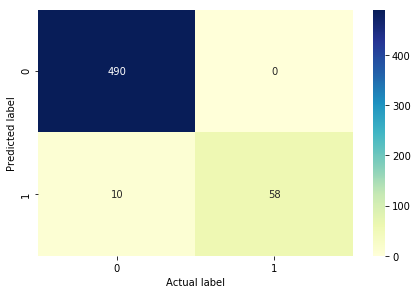

In [65]:
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
ham_vs_spam = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(ham_vs_spam), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.ylabel('Predicted label')
plt.xlabel('Actual label')
print(confusion_matrix(y_test, y_pred))

#### Function to test against new dataset

In [66]:
def pred(msg):
    msg = vectorizer.transform([msg])
    prediction = svm.predict(msg)
    return prediction[0]

In [67]:
msgs = []
count=0
for i in documents['statement']:
    msgs.append(i)
for m in msgs:
    print("Headline: {} which is labeled as \n\n{}\n".format(m, pred(m)))
    count+=1
    if count==10:
        break


Headline: Says the Annies List political group supports third-trimester abortions on demand. which is labeled as 

ham

Headline: When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration. which is labeled as 

ham

Headline: Hillary Clinton agrees with John McCain "by voting to give George Bush the benefit of the doubt on Iran." which is labeled as 

ham

Headline: Health care reform legislation is likely to mandate free sex change surgeries. which is labeled as 

ham

Headline: The economic turnaround started at the end of my term. which is labeled as 

ham

Headline: The Chicago Bears have had more starting quarterbacks in the last 10 years than the total number of tenured (UW) faculty fired during the last two decades. which is labeled as 

ham

Headline: Jim Dunnam has not lived in the district he represents for years now. which is labeled as 

ham

Headline: I'm the only person on this stage who ha

## Doc2Vec Gensim

## Similar news to the claim

#### Import all the dependencies

In [44]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

### Let’s prepare data for training our doc2vec model

Here we have a list of statements from our dataset which we processed earlier as training data. 
Now I have tagged the data and its ready for training.

In [45]:
training_doc = [documents['statement'][9]]
training_doc

['Says GOP primary opponents Glenn Grothman and Joe Leibham cast a compromise vote that cost $788 million in higher electricity costs.']

#### Dataset is used from fakenewschallenge.org

In [46]:
dataset_stances2 = pd.read_csv('train_stances.csv', sep=',')
dataset_stances2.head(10)

,Headline,Body ID,Stance
0,"Soldier shot, Parliament locked down after gun...",0,unrelated
1,Tourist dubbed ‘Spider Man’ after spider burro...,0,unrelated
2,Luke Somers 'killed in failed rescue attempt i...,0,unrelated
3,BREAKING: Soldier shot at War Memorial in Ottawa,0,unrelated
4,Giant 8ft 9in catfish weighing 19 stone caught...,0,unrelated
5,Enormous 20-stone catfish caught with fishing ...,0,unrelated
6,Italian catches huge wels catfish; is it a rec...,0,unrelated
7,Not coming to a store near you: The pumpkin sp...,0,unrelated
8,One gunman killed in shooting on Parliament Hi...,0,unrelated
9,Soldier shot at war memorial in Canada,0,unrelated


In [47]:
dataset_body2 = pd.read_csv('train_bodies.csv', sep=',')
dataset_body2.head(10)

,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...
5,8,There is so much fake stuff on the Internet in...
6,9,"(CNN) -- A meteorite crashed down in Managua, ..."
7,10,"Move over, Netflix and Hulu.\nWord has it that..."
8,11,We’ve all seen the traditional depictions of G...
9,13,A SOLDIER has been shot at Canada’s National W...


In [48]:
UCI_Aggregator_load = pd.read_csv('uci-news-aggregator.csv',sep=',')
UCI_Aggregator_load.shape

(422419, 8)

In [49]:
UCI_Aggregator = UCI_Aggregator_load.dropna(how='any')
UCI_Aggregator.shape

(422417, 8)

In [50]:
UCI_Aggregator.head(10)

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027
5,6,Plosser: Fed May Have to Accelerate Tapering Pace,http://www.nasdaq.com/article/plosser-fed-may-...,NASDAQ,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.nasdaq.com,1394470372212
6,7,Fed's Plosser: Taper pace may be too slow,http://www.marketwatch.com/story/feds-plosser-...,MarketWatch,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.marketwatch.com,1394470372405
7,8,Fed's Plosser expects US unemployment to fall ...,http://www.fxstreet.com/news/forex-news/articl...,FXstreet.com,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.fxstreet.com,1394470372615
8,9,US jobs growth last month hit by weather:Fed P...,http://economictimes.indiatimes.com/news/inter...,Economic Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,economictimes.indiatimes.com,1394470372792
9,10,ECB unlikely to end sterilisation of SMP purch...,http://www.iii.co.uk/news-opinion/reuters/news...,Interactive Investor,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,www.iii.co.uk,1394470501265


In [51]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
LabeledSentence = gensim.models.doc2vec.LabeledSentence

In [52]:
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(dataset_body2['articleBody'])]
print (tagged_data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [476]:
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =0)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    #print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

/anaconda3/lib/python3.6/site-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


Model Saved


In [462]:
dataset_body2.shape

(1683, 3)

In [472]:
dataset_body2['articleBody'][1682]

'ANN ARBOR, Mich. – A pizza delivery man in Michigan got a huge surprise when he made a special delivery to a hotel last week.\n“Rob”, the delivery driver, thought he was dropping off food for a guest, but he was escorted to a conference room where 200 Keller Williams realtors were holding their annual conference.\nThey surprised him with a tip of more than $2,000 plus a VISA gift card, some lottery tickets and letters of encouragement.\nRob was stunned.\nThe realtors said they wanted to do something special for someone in the service industry.'

In [477]:
UCI_Aggregator['TITLE'][0]

'Fed official says weak data caused by weather, should not slow taper'

In [478]:
from gensim.models.doc2vec import Doc2Vec

model= Doc2Vec.load("d2v.model")
#to find the vector of a document which is not in training data
test_data = word_tokenize('Fed official says weak data caused by weather, should not slow taper'.lower())
print("this is test data")
print (test_data)
v1 = model.infer_vector(test_data)
print("V1_infer", v1)

# to find most similar doc using tags
similar_doc = model.docvecs.most_similar('0')
print("Ten most similar doc")
print(similar_doc)

this is test data
['fed', 'official', 'says', 'weak', 'data', 'caused', 'by', 'weather', ',', 'should', 'not', 'slow', 'taper']
V1_infer [-0.14679779  0.00303797 -0.01207398  0.06328587 -0.02022466 -0.05820651
 -0.01979999  0.04099819  0.04611995 -0.00210449 -0.11278879  0.0008722
  0.26338258  0.23309529 -0.03208186 -0.01732718 -0.05816596 -0.13621832
 -0.09033366 -0.26364744]
Ten most similar doc
[('478', 0.9969601631164551), ('1105', 0.994560956954956), ('828', 0.975635826587677), ('1429', 0.9725823998451233), ('711', 0.9687265753746033), ('634', 0.9598904848098755), ('112', 0.9505059719085693), ('715', 0.9465100169181824), ('638', 0.943596601486206), ('512', 0.9371168613433838)]


In [479]:
similar_documents = model.docvecs.most_similar([v1], topn = 1)
print (similar_documents)

[('673', 0.7827357053756714)]


In [483]:
dataset_body2['index'] = dataset_body2.index
print(dataset_body2.loc[dataset_body2['index'] == 673, 'articleBody'])

673    Everyone's been waiting years and years for a ...
Name: articleBody, dtype: object


In [481]:
dataset_body2.head(10)

,Body ID,articleBody,index
0,0,A small meteorite crashed into a wooded area i...,0
1,4,Last week we hinted at what was to come as Ebo...,1
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...,2
3,6,"Posting photos of a gun-toting child online, I...",3
4,7,At least 25 suspected Boko Haram insurgents we...,4
5,8,There is so much fake stuff on the Internet in...,5
6,9,"(CNN) -- A meteorite crashed down in Managua, ...",6
7,10,"Move over, Netflix and Hulu.\nWord has it that...",7
8,11,We’ve all seen the traditional depictions of G...,8
9,13,A SOLDIER has been shot at Canada’s National W...,9


In [516]:
count=1
for i in range(4555):
    claim1=UCI_Aggregator['TITLE'][i]
    claim1.lower()
    new_test_data = word_tokenize(claim1.lower())
    v2 = model.infer_vector(new_test_data)
    similar_documents = model.docvecs.most_similar([v2], topn = 1)
    #print (similar_documents)
    myarray = np.asarray(similar_documents)
    new_a=myarray.squeeze()
    similarity_score=new_a[1]
    article_id = new_a[0]
    if float(similarity_score) > 0.9:
        print ("{}".format(count))
        print ("At index {}, Claim - {}".format(i, claim1))
        print("** Similar news articles **")
        print(dataset_body2.loc[dataset_body2['index'] == int(new_a[0]), 'articleBody'])
        count+=1

1
At index 2953, Claim - Netflix Sees Comcast Performance Boost After Traffic Deal
** Similar news articles **
15    HBO's subscription streaming service will be c...
Name: articleBody, dtype: object
2
At index 2960, Claim - Comcast customers can now watch 'House of Cards' without a Netflix subscription
** Similar news articles **
15    HBO's subscription streaming service will be c...
Name: articleBody, dtype: object
3
At index 2963, Claim - Comcast/Sony deal lets Comcast subscribers watch Netflix shows
** Similar news articles **
15    HBO's subscription streaming service will be c...
Name: articleBody, dtype: object
4
At index 4537, Claim - Pot sales generate $2M in Colorado taxes
** Similar news articles **
907    KFC (NYSE:YUM) Gets Occupational Business Lice...
Name: articleBody, dtype: object


In [515]:
count=1
for i in range(14204, 400000):
    claim1=UCI_Aggregator['TITLE'][i]
    claim1.lower()
    new_test_data = word_tokenize(claim1.lower())
    v2 = model.infer_vector(new_test_data)
    similar_documents = model.docvecs.most_similar([v2], topn = 1)
    #print (similar_documents)
    myarray = np.asarray(similar_documents)
    new_a=myarray.squeeze()
    similarity_score=new_a[1]
    article_id = new_a[0]
    if float(similarity_score) > 0.95:
        print ("{}".format(count))
        print ("At index {}, Claim - {}".format(i, claim1))
        print("** Similar news articles **")
        print(dataset_body2.loc[dataset_body2['index'] == int(new_a[0]), 'articleBody'])
        count+=1

1
At index 147457, Claim - Home > Danny Boyle > Danny Boyle, Leonardo Dicaprio For Steve Jobs Movie?
** Similar news articles **
1468    It looks like Christian Bale will no longer be...
Name: articleBody, dtype: object
2
At index 157211, Claim - Amazon beats Netflix to HBO offerings online with Prime
** Similar news articles **
15    HBO's subscription streaming service will be c...
Name: articleBody, dtype: object


### News Headline

In [524]:
UCI_Aggregator['TITLE'][147457]

'Home > Danny Boyle > Danny Boyle, Leonardo Dicaprio For Steve Jobs Movie?'

### News body from Kaggle Dataset

In [523]:
dataset_body2[dataset_body2['index'] == 1468]

,Body ID,articleBody,index
1468,2211,It looks like Christian Bale will no longer be...,1468


In [525]:
dataset_body2['articleBody'][1468]

'It looks like Christian Bale will no longer be playing Steve Jobs in Danny Boyle\'s upcoming biopic on the Apple founder.\n\nAccording to The Hollywood Reporter, the decision to leave the film was made by Bale himself, who decided the film wasn\'t a good fit.\n\n"Sources say Bale, after much deliberation and conflicting feelings, came to the conclusion he was not right for the part and decided to withdraw," says The Hollywood Reporter.\n\nThe film\'s screenplay, which was written by Academy and Emmy award winning writer Aaron Sorkin, is said to focus on three pivotal keynote presentations given by Steve Jobs.\n\nSeth Rogen is also reportedly in talks to play Apple co-founder Steve Wozniak, though an official offer has yet to be made.\n\nBale\'s departure could come at a bad time for the project, which was scheduled to begin filming later this winter.\n\nYou can read the full report over at The Hollywood Reporter.\n\nSEE ALSO:  Here\'s Why Innovation Dies At Big Tech Companies, Accordi

### Claim stances from Kaggle Dataset

In [542]:
Body_ID = dataset_body2.loc[dataset_body2['index'] == 1468, 'Body ID']
new_df = dataset_stances2[dataset_stances2['Body ID'] == int(Body_ID)]

In [543]:
new_df

,Headline,Body ID,Stance,index
42476,Christian Bale to play Steve Jobs in upcoming ...,2211,disagree,42476
42477,Report: Christian Bale Just Bailed on the Stev...,2211,agree,42477
42478,Gold Apple Watch Edition price? Speculators sa...,2211,unrelated,42478
42479,Christian Bale Is Steve Jobs,2211,disagree,42479
42480,"Apple's New MacBook Will Be A Thinner, Cleaner...",2211,unrelated,42480
42481,Christian Bale set to play Steve Jobs in forth...,2211,disagree,42481
42482,Passenger Wears A Hazmat Suit To Dulles Airpor...,2211,unrelated,42482
42483,Why the Gold Apple Watch Edition Must Cost $10...,2211,unrelated,42483
42484,Christian Bale In Talks To Play Steve Jobs In ...,2211,disagree,42484
42485,Christian Bale quits Steve Jobs movie,2211,agree,42485


### One hot encoding for stance

In [544]:
new_df = new_df.join(new_df['Stance'].str.get_dummies())
new_df

,Headline,Body ID,Stance,index,agree,disagree,discuss,unrelated
42476,Christian Bale to play Steve Jobs in upcoming ...,2211,disagree,42476,0,1,0,0
42477,Report: Christian Bale Just Bailed on the Stev...,2211,agree,42477,1,0,0,0
42478,Gold Apple Watch Edition price? Speculators sa...,2211,unrelated,42478,0,0,0,1
42479,Christian Bale Is Steve Jobs,2211,disagree,42479,0,1,0,0
42480,"Apple's New MacBook Will Be A Thinner, Cleaner...",2211,unrelated,42480,0,0,0,1
42481,Christian Bale set to play Steve Jobs in forth...,2211,disagree,42481,0,1,0,0
42482,Passenger Wears A Hazmat Suit To Dulles Airpor...,2211,unrelated,42482,0,0,0,1
42483,Why the Gold Apple Watch Edition Must Cost $10...,2211,unrelated,42483,0,0,0,1
42484,Christian Bale In Talks To Play Steve Jobs In ...,2211,disagree,42484,0,1,0,0
42485,Christian Bale quits Steve Jobs movie,2211,agree,42485,1,0,0,0


In [545]:
new_df2 = new_df.drop(columns=['Stance'])
new_df2

,Headline,Body ID,index,agree,disagree,discuss,unrelated
42476,Christian Bale to play Steve Jobs in upcoming ...,2211,42476,0,1,0,0
42477,Report: Christian Bale Just Bailed on the Stev...,2211,42477,1,0,0,0
42478,Gold Apple Watch Edition price? Speculators sa...,2211,42478,0,0,0,1
42479,Christian Bale Is Steve Jobs,2211,42479,0,1,0,0
42480,"Apple's New MacBook Will Be A Thinner, Cleaner...",2211,42480,0,0,0,1
42481,Christian Bale set to play Steve Jobs in forth...,2211,42481,0,1,0,0
42482,Passenger Wears A Hazmat Suit To Dulles Airpor...,2211,42482,0,0,0,1
42483,Why the Gold Apple Watch Edition Must Cost $10...,2211,42483,0,0,0,1
42484,Christian Bale In Talks To Play Steve Jobs In ...,2211,42484,0,1,0,0
42485,Christian Bale quits Steve Jobs movie,2211,42485,1,0,0,0


### Data Visualization
#### plot the agree and disagree 

Text(0.5,1,'Disagree')

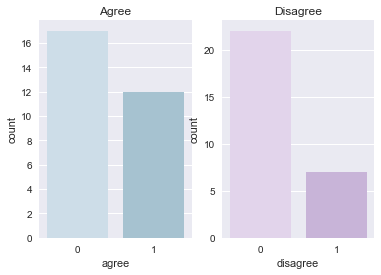

In [554]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")
ax = plt.subplot(1,2,1)
sns.countplot(x="agree", data=new_df2, palette = sns.cubehelix_palette(n_colors = 7, start = 2.4, rot = .1), ax = ax)
ax.set_title('Agree')

ax = plt.subplot(1,2,2)
sns.countplot(x="disagree", data=new_df2, palette = sns.cubehelix_palette(n_colors = 7, start = 3, rot = .1), ax = ax)
ax.set_title('Disagree')